### Grading Rubric
#### Q1
1 pt for group submission, 0 pt for individual submission 

#### Q2
(a-b) 6pt total
- correctly implemented SGD: 1pt
- convergence analysis: wall time (0.5pt), number of epochs (0.5pt)
- reasonable error rates (1pt)
- Apply SGD to un-normalized data (1pt) and normalized data (1pt)
- Features with largest positive and negative weights are as reported. (0.5pt)
- Correct interpretation about different feature weights learnt from un-normalized and normalized data. (0.5pt)

(c) 1pt. 
- reasonable data transformation described or implemented. 

#### Q3
- apply decision tree with varying max depth (1pt)
- reasonable error rates and analysis of the effect varying depth(1pt)
- apply random forest with differing number of trees, get >0.8 test accuracy (1pt)

#### Q4
- Train MLPClassifier on normalized data (1pt)
- Explore hyperparamter space: varying number of nodes, layers, alphas etc. (1pt)
- Report training and test accuracies (1pt)
- Get test accuracy to be above 0.8 (1pt) (but not un-realistically high, best performance reported on kaggle is about 0.85)

#### Q5
- correct forward pass (1pt)
- correct backward pass (1pt)

### Q0. read, split and normalize data

In [63]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [64]:
df = pd.read_csv("./pima_data/diabetes.csv")

In [65]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [66]:
# split data
X_cols = [i for i in df.columns if i!='Outcome']
X = df[X_cols].astype("float")
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0)

In [67]:
print("all data:",X.shape[0],
      "\nTrain data:", X_train.shape[0],
      "\nTest data:", X_test.shape[0])
print("\nRatio of positive labels: {0:.4f}".format(sum(y)/len(y)), 
      "\nRatio of positive labels in train: {0:.4f}".format(sum(y_train)/len(y_train)), 
      "\nRatio of positive labels in test: {0:.4f}".format(sum(y_test)/len(y_test)))

all data: 768 
Train data: 614 
Test data: 154

Ratio of positive labels: 0.3490 
Ratio of positive labels in train: 0.3485 
Ratio of positive labels in test: 0.3506


In [68]:
""" normalize data 
note: first normalize then split to train and test 
to make sure the train and test data distribution comes from the same data distribution 
in other words, 
to make sure normalization doesn't affect train/test distribution differently
"""
scaler = MinMaxScaler(feature_range=(0, 1))
X_norm = scaler.fit_transform(X)
X_train_norm = X_norm[X_train.index]
X_test_norm = X_norm[X_test.index]

In [69]:
# turn all into numpy array
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

In [70]:
print("Feature average before normalization")
X.mean()

Feature average before normalization


Pregnancies                   3.845052
Glucose                     120.894531
BloodPressure                69.105469
SkinThickness                20.536458
Insulin                      79.799479
BMI                          31.992578
DiabetesPedigreeFunction      0.471876
Age                          33.240885
dtype: float64

In [71]:
print("Feature average after normalization")
pd.DataFrame(X_norm, columns=X.columns).mean()

Feature average after normalization


Pregnancies                 0.226180
Glucose                     0.607510
BloodPressure               0.566438
SkinThickness               0.207439
Insulin                     0.094326
BMI                         0.476790
DiabetesPedigreeFunction    0.168179
Age                         0.204015
dtype: float64

### Q2

In [56]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def dJdW(X, y, w):
    y_pred = sigmoid(np.dot(X, w))
    return (y - y_pred) * X

def log_likelihood(y, y_pred):
    y_pred = np.clip(y_pred, 1e-12, 1-1e-12) # prevent log0 error
    return np.sum(y * np.log(y_pred) + (1-y) * np.log(1-y_pred))/len(y)

def SGD(X, y, max_epochs=100, step_size=1e-4, timeit=False):
    # add extra feature of all 1s to X
    X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1) 
    # random initialize weights
    w = np.random.random(X.shape[1]) 
    logloss = []
    accuracies = []
    best_accuracy = 0
    # stop training if accuracy hasn't improved for patience number of epochs
    patience = 20
    no_improvement = 0
    for i in range(max_epochs):
        # shuffle data
        idx = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[idx], y[idx]
        # go through shuffled data point by point
        for j in range(X.shape[0]):
            w = w + step_size * dJdW(X[j], y[j], w)
        
        # at the end of every epoch, calculate log-likelihood and 
        y_pred = sigmoid(np.dot(X, w))
        loglikelihood = log_likelihood(y, y_pred)
        accuracy = np.sum((y_pred >= 0.5) == y)/len(y)
        logloss.append(-loglikelihood)
        accuracies.append(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_w = w
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= patience:
            break
    
    if not timeit:
        # no plotting if using %timeit function
        plt.figure(dpi=120)
        plt.plot(logloss, color="red", label=" train logloss")
        plt.plot(accuracies, color="green", label="train accuracy")
        plt.xlabel("number of epochs")
        plt.legend()
        plt.title("step size: {0}, best accuracy: {1:.3f}, \n it takes {2} epochs to converge".format(
            step_size, best_accuracy, len(logloss)-patience))
        plt.show()
    
    return best_w

### Q2(a) time it takes to converge based on different step size

In [18]:
%timeit SGD(X_train, y_train, step_size=1e-3, timeit=True)

10 loops, best of 3: 206 ms per loop


In [151]:
%timeit SGD(X_train, y_train, step_size=1e-4, timeit=True)

294 ms ± 62.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
%timeit SGD(X_train, y_train, step_size=1e-5, timeit=True)

346 ms ± 40 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [153]:
%timeit SGD(X_train, y_train, step_size=1e-6, timeit=True)

391 ms ± 87.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Q2(a) Number of epochs to converge

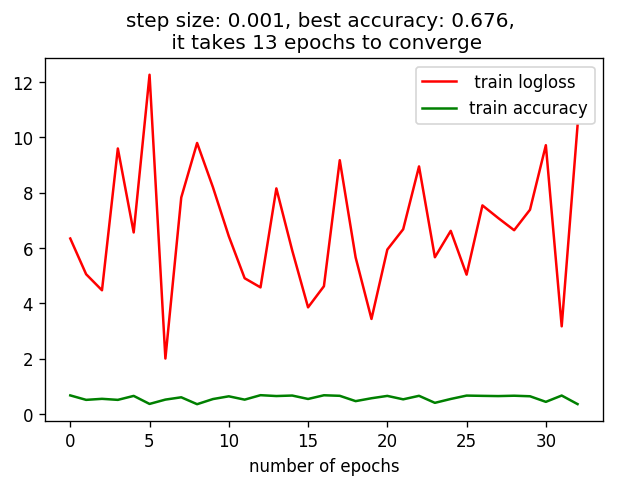

array([ 0.90911082,  0.29744639, -0.50846112, -0.21521434, -0.05626776,
       -0.12535658,  0.44739936, -0.09646775,  0.3020691 ])

In [19]:
SGD(X_train, y_train, step_size=1e-3)

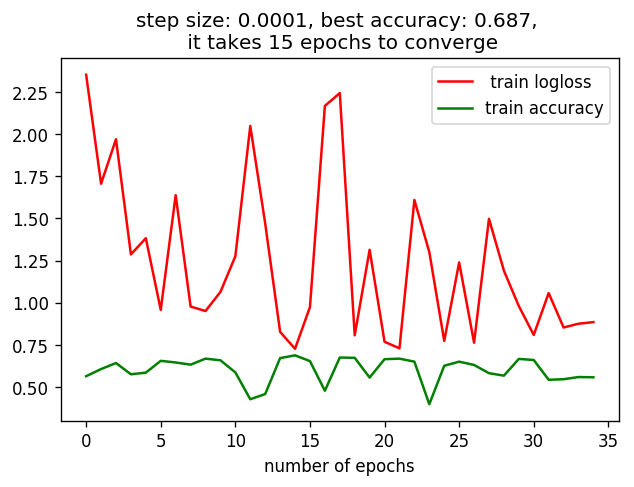

array([ 0.42291031,  0.01600596, -0.05298792, -0.02023652,  0.00451957,
        0.01511554,  0.15561413, -0.05149026,  0.1351843 ])

In [20]:
SGD(X_train, y_train, step_size=1e-4)

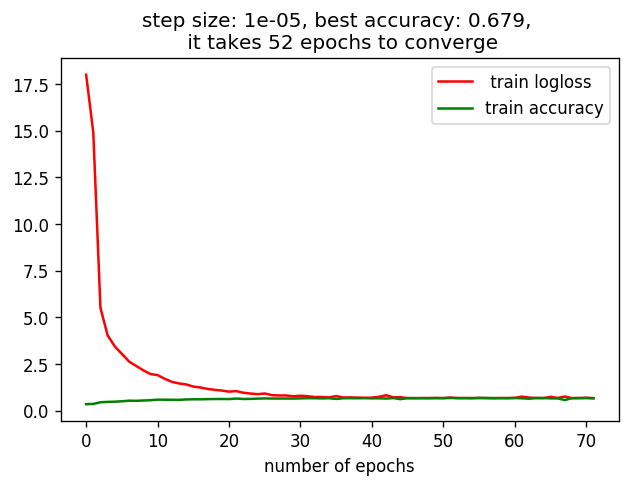

array([ 3.31033467e-01,  7.53281919e-03, -4.14010278e-02,  5.58644589e-04,
        3.23659787e-03, -1.16520854e-02,  6.86220576e-01, -3.86491843e-02,
        5.23872622e-01])

In [21]:
SGD(X_train, y_train, step_size=1e-5, max_epochs=200)

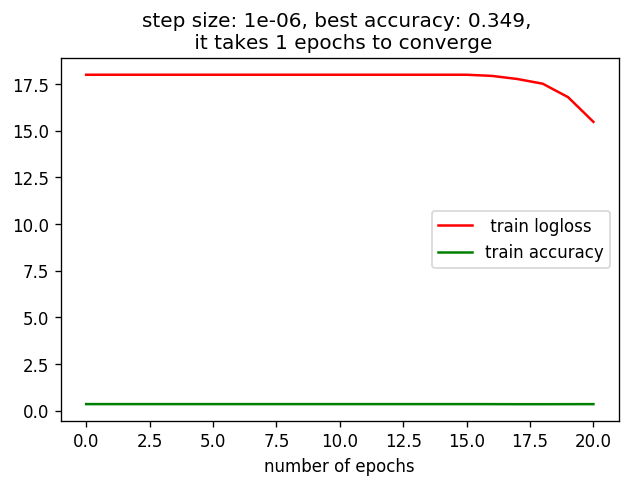

array([0.98720824, 0.89549975, 0.53771974, 0.48108853, 0.27235261,
       0.60906648, 0.89572802, 0.83141719, 0.82876246])

In [22]:
SGD(X_train, y_train, step_size=1e-6, max_epochs=1000)

### Q2(a) error rate, average log-likelihood for train and test 

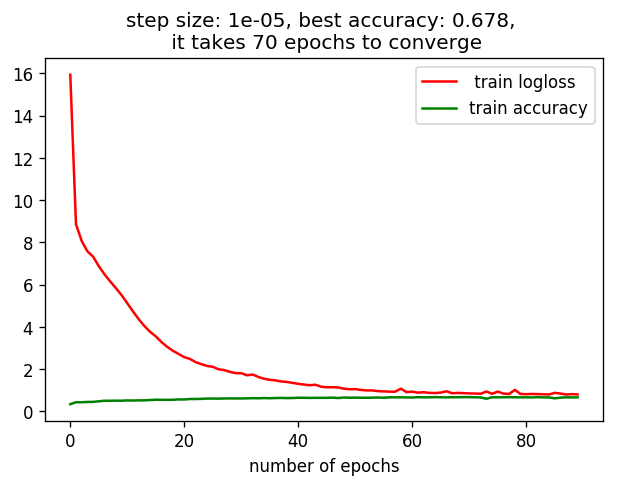

In [41]:
w = SGD(X_train, y_train, step_size=1e-5)

In [42]:
def forward(X, y, w, label="Train"):
    X = np.concatenate((X, np.ones(X.shape[0]).reshape(-1, 1)), axis=1) 
    y_pred = sigmoid(np.dot(X, w))
    error = np.sum((y_pred > 0.5) != y)/len(y)
    ll = log_likelihood(y, y_pred)
    print("{0} error rate: {1:.4f}".format(label, error))
    print("{0} average log-likelihood: {1:.4f}".format(label, ll))

In [43]:
forward(X_train, y_train, w, label="Train")

Train error rate: 0.3225
Train average log-likelihood: -0.8691


In [44]:
forward(X_test, y_test, w, label="Test")

Test error rate: 0.3247
Test average log-likelihood: -0.7909


### Q2(a) feature weights 
- all features sorted by weights are shown bellow

In [45]:
sorted(tuple(zip(list(X.columns) + ["Bias"], list(w))), 
       key=lambda x:x[1])

[('Age', -0.07614957262805815),
 ('BloodPressure', -0.05045240522022064),
 ('BMI', -0.05003614657759779),
 ('Insulin', -0.002098872720499814),
 ('SkinThickness', 0.02192964503377327),
 ('Glucose', 0.02253921936409594),
 ('Bias', 0.35081504884766407),
 ('Pregnancies', 0.7050502600218327),
 ('DiabetesPedigreeFunction', 0.7514025120885233)]

### Q2(b) 

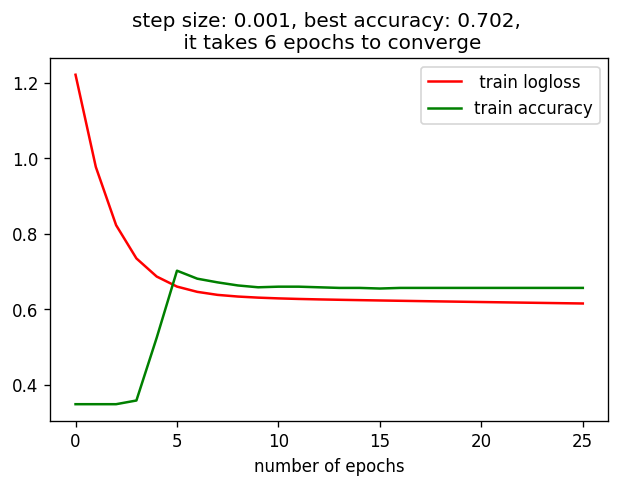

In [46]:
w_norm = SGD(X_train_norm, y_train, step_size=1e-3, timeit=False)

In [47]:
forward(X_train_norm, y_train, w_norm, label="Normalized Train")

Normalized Train error rate: 0.2980
Normalized Train average log-likelihood: -0.6598


In [48]:
forward(X_test_norm, y_test, w_norm, label="Normalized Test")

Normalized Test error rate: 0.3117
Normalized Test average log-likelihood: -0.6628


In [49]:
sorted(tuple(zip(list(X.columns) + ["Bias"], list(w_norm))), 
       key=lambda x:x[1])

[('Bias', -0.40539997778021575),
 ('BloodPressure', -0.21995067335459262),
 ('Pregnancies', -0.07826476205561851),
 ('DiabetesPedigreeFunction', -0.07767522910835412),
 ('SkinThickness', -0.028743769989410396),
 ('Glucose', 0.28673709111005935),
 ('Age', 0.3830262051727753),
 ('BMI', 0.40069403452593255),
 ('Insulin', 0.7258616130631608)]

In [55]:
# cosine similarity between weights learnt from un-normalized and normalized data
# shows these two weights are not the same at all
np.dot(w, w_norm)/(np.linalg.norm(w)*np.linalg.norm(w_norm))

-0.24770813614356685

#### Analysis
About feature weights learnt from normalized and un-normalized data. For features with high values such as Glucose (average value is 120 from unnormalized data), the glucose weight of model trained from un-normalized data is much lower than the glucose weight of model trained from normalized data. This means the former model adjusted to the high numerical value of glucose by reducing the weight of this feature. This means that the feature weights learnt from un-normalized data is heavily influenced by feature scaling, and therefore is not represetative of how important a feature is. Whereas a feature weight learnt from normalized data, since all features are on the same scale, their weights then represent how heavily this weight influence the final prediction. And thus the feature weight learnt from normalized data is much more meaningful. 

### Q2(c)
- try polynomial feature transformation: 
turn [x1, x2] to [1, x1^2, x1\*x2, x2^2]

- log inverse transformation
turn [x1, x2] to [log(1/x1), log(1/x2)]

In [88]:
from sklearn.preprocessing import PolynomialFeatures

In [117]:
# degree 2 polynomial feature
poly2 = PolynomialFeatures(2)
X_train_poly2 = poly2.fit_transform(X_train_norm)[:, 1:]
X_test_poly2 = poly2.fit_transform(X_test_norm)[:, 1:]
print(X_train_poly2.shape)

# log inverse transformation
X_train_inverse = np.concatenate([np.log(1/(X_train_norm+1e-12)), X_train_norm], axis=1)
X_test_inverse = np.concatenate([np.log(1/(X_test_norm+1e-12)), X_test_norm], axis=1)
print(X_train_inverse.shape)

# polynomial AND log inverse transform
X_train_both = np.concatenate([X_train_poly2, X_train_inverse], axis=1)
X_test_both = np.concatenate([X_test_poly2, X_test_inverse], axis=1)
print(X_train_both.shape)

(614, 44)
(614, 16)
(614, 60)


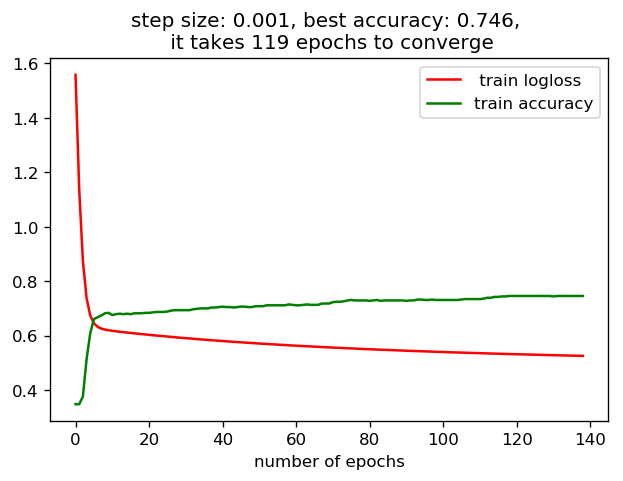

In [93]:
w_poly2 = SGD(X_train_poly2, y_train, max_epochs=200, step_size=1e-3)

In [118]:
forward(X_train_poly2, y_train, w_poly2, 
        label="Polynomial Transform Train")

forward(X_test_poly2, y_test, w_poly2, 
        label="Polynomial Transform Test")

Polynomial Transform Train error rate: 0.2541
Polynomial Transform Train average log-likelihood: -0.5327
Polynomial Transform Test error rate: 0.2792
Polynomial Transform Test average log-likelihood: -0.5264


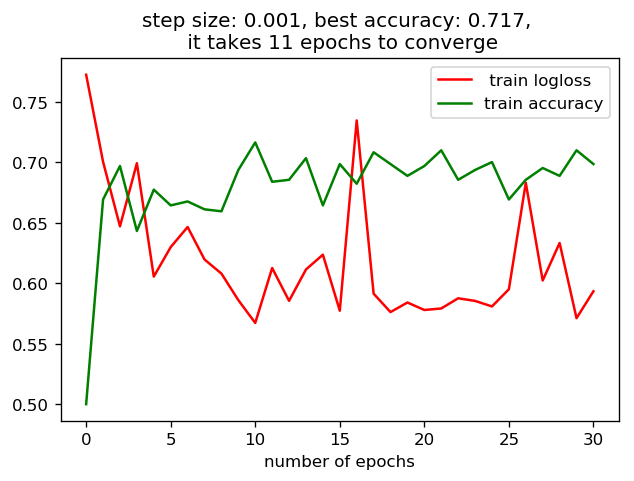

Log Inverse Transform Train error rate: 0.2541
Log Inverse Transform Train average log-likelihood: -0.5327
Log Inverse Transform Test error rate: 0.2792
Log Inverse Transform Test average log-likelihood: -0.5264


In [114]:
w_inverse = SGD(X_train_inverse, y_train, max_epochs=200, step_size=1e-3)
forward(X_train_poly2, y_train, w_poly2, label="Log Inverse Transform Train")
forward(X_test_poly2, y_test, w_poly2, label="Log Inverse Transform Test")

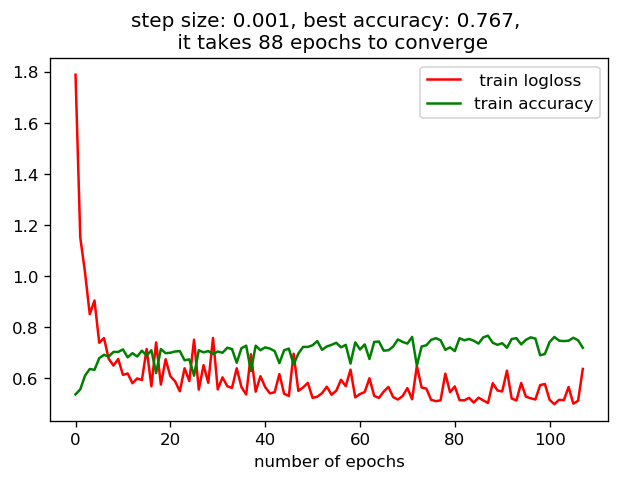

Log Inverse and Polynomial Transform Train error rate: 0.2329
Log Inverse and Polynomial Transform Train average log-likelihood: -0.5040
Log Inverse and Polynomial Transform Test error rate: 0.2662
Log Inverse and Polynomial Transform Test average log-likelihood: -0.5024


In [121]:
w_both = SGD(X_train_both, y_train, max_epochs=200, step_size=1e-3)
forward(X_train_both, y_train, w_both, label="Log Inverse and Polynomial Transform Train")
forward(X_test_both, y_test, w_both, label="Log Inverse and Polynomial Transform Test")

### Q3 

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [73]:
def dtree(X_train, X_test, y_train, y_test, normal="Un-normalized"):
    train_accus = []
    test_accus = []
    train_times = []
    depth_range = list(range(1, 16))
    for depth in depth_range:
        tree = DecisionTreeClassifier(max_depth=depth)
        t0 = time.time()
        tree.fit(X_train, y_train)
        train_times.append(time.time()-t0)
        y_train_pred = tree.predict(X_train)
        train_accuracy = accuracy_score(y_train_pred, y_train)
        test_accuracy = accuracy_score(tree.predict(X_test), y_test)
        train_accus.append(train_accuracy)
        test_accus.append(test_accuracy)
        
    fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, dpi=100, figsize=(4, 6))
    axes[0].plot(depth_range, train_accus, label="train accuracy")
    axes[0].plot(depth_range, test_accus, label="test accuracy")
    axes[0].legend()
    axes[0].set_xlabel("max depth")
    axes[0].set_title("Decision tree on {} data".format(normal))
    axes[0].grid()
    
    axes[1].plot(depth_range, train_times, label="train time (seconds)")
    axes[1].legend()
    axes[1].set_ylabel("seconds")
    axes[1].set_xlabel("max depth")
    plt.show()

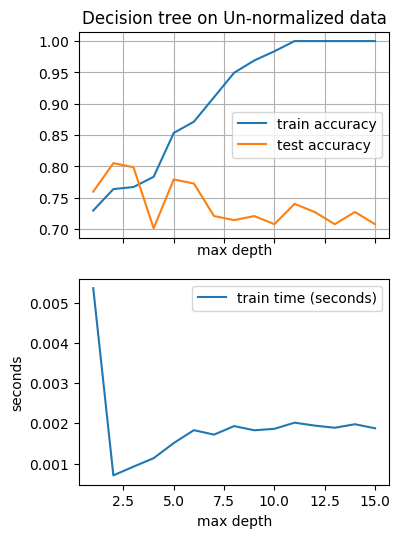

In [74]:
x = dtree(X_train, X_test, y_train, y_test)

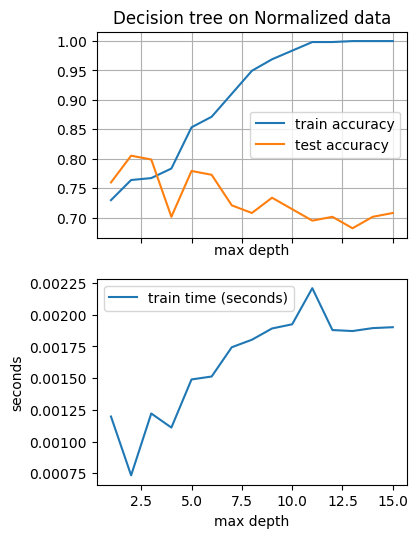

In [75]:
x = dtree(X_train_norm, X_test_norm, y_train, y_test, normal="Normalized")

##### Analysis: 
- When max_depth is larger, it allow more complex and deeper trees to be fitted to the data, which results in higher training accuracy. However, complex trees means overfitting since the exact data points can be memorized in a very complex and deep tree, and such a tree is not good at generalizing to unseen data. 

- It takes longer to train a decision tree with larger max_depth, because as the tree grows deeper, there are more splits that need to be calculated, and thus the training and inference of deeper tree are slower. 

- Normalization doesn't affect decision tree result because with decision tree, a feature value is used to split data samples based on some purity measure. Whether a feature has a value of 100 or 1, the resulting split is not affected by the feature value. The above result shows that un-normalized data and normalized data has the same results with decision tree. 

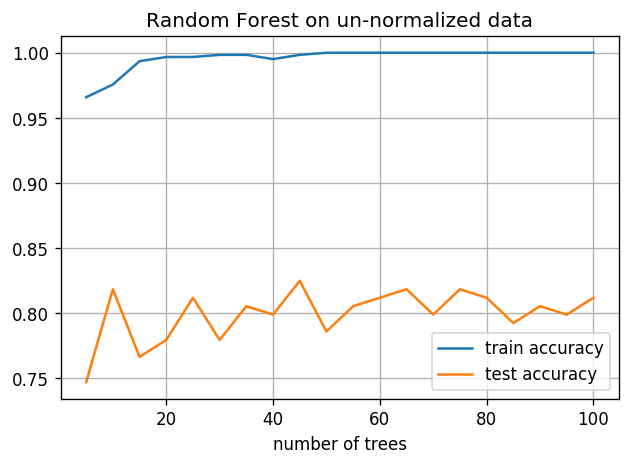

best test accuracy 0.8246753246753247


In [76]:
# random forest
train_accus = []
test_accus = []
ntree_range = np.arange(5, 101, 5)
for n_trees in ntree_range:
    forest = RandomForestClassifier(n_estimators=n_trees)
    forest.fit(X_train, y_train)
    y_train_pred = forest.predict(X_train)
    train_accuracy = accuracy_score(y_train_pred, y_train)
    test_accuracy = accuracy_score(forest.predict(X_test), y_test)
    train_accus.append(train_accuracy)
    test_accus.append(test_accuracy)   
    
plt.figure(dpi=120)
plt.plot(ntree_range, train_accus, label="train accuracy")
plt.plot(ntree_range, test_accus, label="test accuracy")
plt.legend()
plt.xlabel("number of trees")
plt.title("Random Forest on un-normalized data")
plt.grid(which="both")
plt.show()

print("best test accuracy", np.max(test_accus))

### Q4 

In [60]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

10,60,110,160,210,260,310,360,410,460,510,560,610,660,710,760,810,860,910,960,

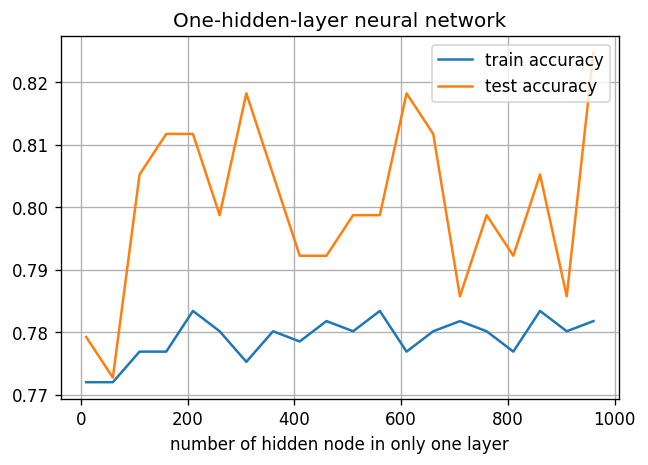

In [236]:
# just one layer with varying sizes
train_accus = []
test_accus = []
node_range = np.arange(10, 1001, 50)

for n_node in node_range:
    print(n_node, end=",")
    net = MLPClassifier(hidden_layer_sizes=(n_node), max_iter=1000000)
    net.fit(X_train_norm, y_train)
    train_accuracy = accuracy_score(net.predict(X_train_norm), y_train)
    test_accuracy = accuracy_score(net.predict(X_test_norm), y_test)
    train_accus.append(train_accuracy)
    test_accus.append(test_accuracy) 
    
plt.figure(dpi=120)
plt.plot(node_range, train_accus, label="train accuracy")
plt.plot(node_range, test_accus, label="test accuracy")
plt.legend()
plt.xlabel("number of hidden node in only one layer")
plt.title("One-hidden-layer neural network")
plt.grid(which="both")
plt.show()

##### analysis
it looks like the training data is not overfitting even with large number of hidden nodes, which is concerning because a sophisticated enough NN model should always be able to overfit to a known data. Making the MLPClassifier overfit to the training data such that the accuracy is close to 1 is very important, this demonstrates that we have a model that knows what it's doing and there is no bug that's coming from a bad model. Next I am trying various parameters to make this happen. 

The parameters I am trying, essentially, is to make a larger network, and have it train longer, for more iterations, and the stopping criteria is set to be very lenient, meaning that the model will train as long as possible. And I get rid of regularization for now because I actually want the model to overfit.

Model bellow seems to be doing a decent job.

In [261]:
net = MLPClassifier(hidden_layer_sizes=(2000, ), 
                    solver="lbfgs",
                    max_iter=1000, alpha=0, 
                    tol=1e-12)
net.fit(X_train_norm, y_train)
train_accuracy = accuracy_score(net.predict(X_train_norm), y_train)
test_accuracy = accuracy_score(net.predict(X_test_norm), y_test)
print("train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)

train accuracy 1.0
Test accuracy 0.7337662337662337


#### Now reduce network size, increase tolerance, increase regularization

10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,310,330,350,370,390,410,430,450,470,490,510,530,550,570,590,610,630,650,670,690,710,730,750,770,790,810,830,850,870,890,910,930,950,970,990,

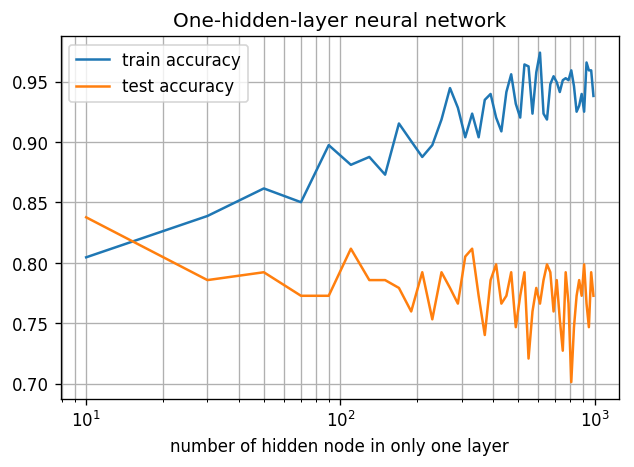

In [294]:
# rerun previous graph with better parameters for better results. 

# just one layer with varying hidden nodes
train_accus = []
test_accus = []
node_range = np.arange(10, 1001, 20)

for n_node in node_range:
    print(n_node, end=",")
    net = MLPClassifier(hidden_layer_sizes=(n_node),
                        solver="lbfgs",
                        max_iter=500, alpha=1e-5, 
                        tol=1e-7)
    net.fit(X_train_norm, y_train)
    train_accuracy = accuracy_score(net.predict(X_train_norm), y_train)
    test_accuracy = accuracy_score(net.predict(X_test_norm), y_test)
    train_accus.append(train_accuracy)
    test_accus.append(test_accuracy)

plt.figure(dpi=120)
plt.plot(node_range, train_accus, label="train accuracy")
plt.plot(node_range, test_accus, label="test accuracy")
plt.legend()
plt.xlabel("number of hidden node in only one layer")
plt.xscale("log")
plt.title("One-hidden-layer neural network")
plt.grid(which="both")
plt.show()

10,20,30,40,50,60,70,80,90,100,200,

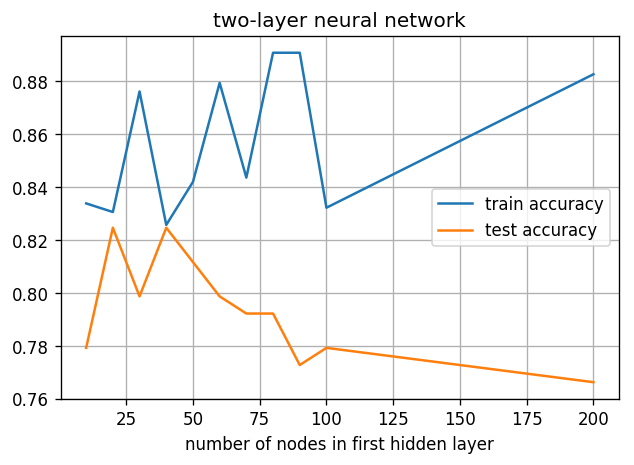

In [271]:
# 2 hidden layers
# with 80 nodes at second hidden layer (determined from previous run)
# and varying nodes at first hidden layer
train_accus = []
test_accus = []
node_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

for node in node_range:
    print(node, end=",")
    net = MLPClassifier(hidden_layer_sizes=(node,80,), 
                        solver="lbfgs",
                        max_iter=500, alpha=1e-5, 
                        tol=1e-7)
    net.fit(X_train_norm, y_train)
    train_accuracy = accuracy_score(net.predict(X_train_norm), y_train)
    test_accuracy = accuracy_score(net.predict(X_test_norm), y_test)
    train_accus.append(train_accuracy)
    test_accus.append(test_accuracy)
    
plt.figure(dpi=120)
plt.plot(node_range, train_accus, label="train accuracy")
plt.plot(node_range, test_accus, label="test accuracy")
plt.legend()
plt.xlabel("number of nodes in first hidden layer")
plt.title("two-layer neural network")
plt.grid(which="both")
plt.show()

10,20,50,80,90,100,200,500,1000,

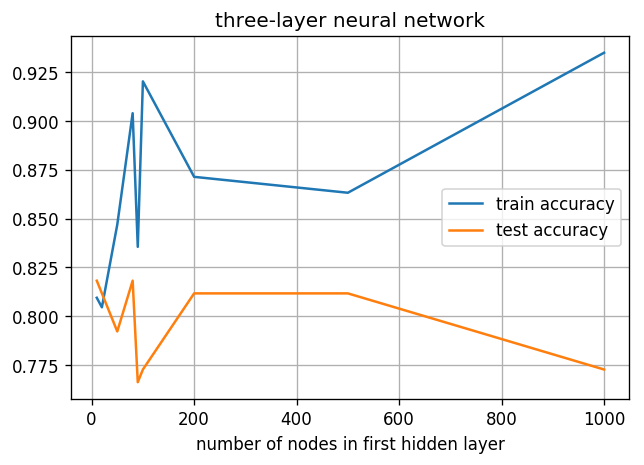

In [273]:
# 3 hidden layers
# with 40, 80 nodes at second and third hidden layer (determined from previous run)
# and varying nodes at first hidden layer
train_accus = []
test_accus = []
node_range = [10, 20, 50, 80, 100, 200, 500, 1000]

for node in node_range:
    print(node, end=",")
    net = MLPClassifier(hidden_layer_sizes=(node,40, 80,), 
                        solver="lbfgs",
                        max_iter=500, alpha=1e-5, 
                        tol=1e-7)
    net.fit(X_train_norm, y_train)
    train_accuracy = accuracy_score(net.predict(X_train_norm), y_train)
    test_accuracy = accuracy_score(net.predict(X_test_norm), y_test)
    train_accus.append(train_accuracy)
    test_accus.append(test_accuracy)
    
plt.figure(dpi=120)
plt.plot(node_range, train_accus, label="train accuracy")
plt.plot(node_range, test_accus, label="test accuracy")
plt.legend()
plt.xlabel("number of nodes in first hidden layer")
plt.title("three-layer neural network")
plt.grid(which="both")
plt.show()

##### Analysis 
hidden node size of range (20, 20) to (50, 80) seems to work best

In [61]:
net = MLPClassifier(hidden_layer_sizes=(20, 20,), 
                        solver="lbfgs",
                        max_iter=500, alpha=1e-5, 
                        tol=1e-7)
net.fit(X_train_norm, y_train)
train_accuracy = accuracy_score(net.predict(X_train_norm), y_train)
test_accuracy = accuracy_score(net.predict(X_test_norm), y_test)
print(train_accuracy, test_accuracy)

0.8143322475570033 0.8246753246753247


### Q5

#### Forward pass:
$$ Z_3 = w_{31} * x_1 + w_{32} * x_2 = 3 $$

$$ A_3 = Relu(Z_3) = 3 $$

$$ Z_4 = w_{41} * x_1 + w_{42} * x_2 = -1 $$

$$ A_4 = Relu(Z_4) = 0 $$

$$ Z_5 = w_{51} * x_1 + w_{52} * x_2 = -3 $$

$$ A_5 = Relu(Z_5) = 0 $$

$$ A_6 = Z_6 = w_{64} * A_4 + w_{65} * A_5 + w_{63} * A_3 = 3 $$

$$ Loss (L) = \frac{1}{2}(A_6 - t)^2 = \frac{1}{2} * (3-2)^2 = 0.5 $$

#### Backward pass
$$ \delta_6 = \frac{\partial L}{\partial A_{6}} = (A_6 - t) = 1 $$

- Second layer:

$$ \frac{\partial L}{\partial w_{63}} = \frac{\partial L}{\partial A_6} * \frac{\partial A_6}{\partial w_{63}} = \delta_6 * A_3 = 1 * 3 = 3$$

$$ \frac{\partial L}{\partial w_{64}} = \delta_6 * A_4 = 0 $$

$$ \frac{\partial L}{\partial w_{65}} = \delta_6 * A_5 = 0 $$

- First layer:

$$ \frac{\partial L}{\partial w_{31}} = \frac{\partial L}{\partial A_{6}} * \frac{\partial A_6}{\partial A_{3}} * \frac{\partial A_3}{\partial w_{31}} = \delta_6 * w_{63} * relu'(z_3) * x_1 $$

or in general form

$$ \delta_i = \frac{\partial L}{\partial A_{6}} * \frac{\partial A_6}{\partial A_{i}} = \delta_6 * w_{6i} $$

$$ \delta_3 = \delta_6 * w_{63} = 1 * 1 = 1 $$
$$ \delta_4 = \delta_6 * w_{64} = 1 * 1 = 1 $$
$$ \delta_5 = \delta_6 * w_{65} = 1 * 1 = 1 $$

$$ \frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial A_{6}} * \frac{\partial A_6}{\partial A_{i}} * \frac{\partial A_i}{\partial w_{ij}} = \delta_i * relu'(z_i) * x_j$$



where relu'(z) is the derivative of ReLU activation function: 

$$
relu'(z) = 
\begin{cases}
  1 & \text{$z > 0$ } \\
  0 & \text{$z <= 0$}
\end{cases}
$$

$$ \frac{\partial L}{\partial w_{31}} = \delta_3 * 1 * x_1 = 1 * 1 * 1 = 1 $$

$$ \frac{\partial L}{\partial w_{32}} = \delta_3 * 1 * x_2 = 1 * 1 * 2 = 2 $$

$$ \frac{\partial L}{\partial w_{41}} = \delta_4 * 1 * x_1 = 1 * 0 * 1 = 0 $$

$$ \frac{\partial L}{\partial w_{42}} = \delta_4 * 1 * x_2 = 1 * 0 * 2 = 0 $$

$$ \frac{\partial L}{\partial w_{51}} = \delta_5 * 1 * x_1 = 1 * 0 * 1 = 0 $$

$$ \frac{\partial L}{\partial w_{52}} = \delta_5 * 1 * x_2 = 1 * 0 * 2 = 0 $$

- update w:

$$ w_{63} := w_{63} - \eta * \frac{\partial L}{\partial w_{63}} = 1 - 0.1 * 3 = 0.7 $$

$$ w_{64} := w_{64} - \eta * \frac{\partial L}{\partial w_{64}} = 1 - 0.1 * 0 = 1 $$

$$ w_{65} := w_{65} - \eta * \frac{\partial L}{\partial w_{65}} = 1 - 0.1 * 0 = 1 $$

$$ w_{31} := w_{31} - \eta * \frac{\partial L}{\partial w_{31}} = 1 - 0.1 * 1 = 0.9 $$

$$ w_{32} := w_{32} - \eta * \frac{\partial L}{\partial w_{32}} = 1 - 0.1 * 2 = 0.8 $$

$$ w_{41} := w_{41} - \eta * \frac{\partial L}{\partial w_{41}} = 1 - 0.1 * 0 = 1 $$

$$ w_{42} := w_{42} - \eta * \frac{\partial L}{\partial w_{42}} = -1 - 0.1 * 0 = -1 $$

$$ w_{51} := w_{51} - \eta * \frac{\partial L}{\partial w_{51}} = -1 - 0.1 * 0 = -1 $$

$$ w_{52} := w_{52} - \eta * \frac{\partial L}{\partial w_{52}} = -1 - 0.1 * 0 = -1 $$